In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Flatten, concatenate, Dropout, Multiply, Lambda
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
df1 = pd.read_csv("UNSW_filtered_data.csv")
df1.shape

(2784, 44)

In [3]:
df2= pd.read_csv("UNSW_augmented_filtered_data.csv")
df2.shape

(257673, 44)

In [4]:
df=pd.concat([df1,df2],axis=0)
df.shape

(260457, 44)

In [5]:
## From the IMOA feature selecting
selected_features = ['dur','proto','service','state','sbytes','dbytes','dload','sloss','sinpkt','sjit','swin','stcpb','attack_cat',
'dwin','synack','ackdat','dmean','trans_depth','ct_state_ttl','ct_dst_src_ltm','ct_ftp_cmd','ct_src_ltm']
# Drop columns not in the list
df_filtered = df[selected_features]

In [6]:
X = df_filtered.iloc[:, :].values  # Features (excluding the label column)
y = df.iloc[:, -1].values   # Labels

In [39]:
X.shape

(260457, 22)

In [40]:
y.shape

(260457,)

In [41]:
y

array([1., 1., 1., ..., 1., 1., 1.])

In [43]:
# Ensure y is correctly shaped for binary classification
if len(y.shape) == 2 and y.shape[1] == 1:
    y = y.flatten()  # Flatten if it's a column vector
print(f"Shape of y_train after flattening: {y.shape}")

Shape of y_train after flattening: (260457,)


In [44]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [45]:
# Reshape X for CNN and LSTM input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [46]:
# Define CNN Model
def create_cnn_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Single output for binary classification
    model = Model(inputs, output)
    return model

In [47]:
# Define LSTM Model
def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(32)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Single output for binary classification
    model = Model(inputs, output)
    return model

In [48]:
# Define FNN Model
def create_fnn_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Single output for binary classification
    model = Model(inputs, output)
    return model

In [49]:
# Create individual models
cnn_model = create_cnn_model(X_train_cnn.shape[1:])
lstm_model = create_lstm_model(X_train_cnn.shape[1:])
fnn_model = create_fnn_model(X_train.shape[1])

In [50]:
# Compile the individual models
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
fnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# Fit the individual models
cnn_history = cnn_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [52]:
lstm_history = lstm_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [53]:
fnn_history = fnn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=0)

In [54]:
# Get validation accuracy for dynamic weighting
cnn_val_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
lstm_val_accuracy = lstm_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
fnn_val_accuracy = fnn_model.evaluate(X_test, y_test, verbose=0)[1]

In [55]:
# Calculate dynamic weights based on validation accuracy
total_accuracy = cnn_val_accuracy + lstm_val_accuracy + fnn_val_accuracy
weights = {
    'cnn': cnn_val_accuracy / total_accuracy,
    'lstm': lstm_val_accuracy / total_accuracy,
    'fnn': fnn_val_accuracy / total_accuracy
}

In [56]:
# Weighted outputs using Lambda layers
cnn_weighted_output = Lambda(lambda x: x * weights['cnn'])(cnn_model.output)
lstm_weighted_output = Lambda(lambda x: x * weights['lstm'])(lstm_model.output)
fnn_weighted_output = Lambda(lambda x: x * weights['fnn'])(fnn_model.output)


In [57]:
# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')


In [58]:
# Apply attention mechanism on combined output
def attention_mechanism(inputs):
    attention_weights = Dense(inputs.shape[-1], activation='softmax', name='attention_weights')(inputs)
    attention_output = Multiply(name='attention_output')([inputs, attention_weights])
    return attention_output, attention_weights

attention_output, attention_weights = attention_mechanism(combined)

In [59]:
# Final output layer for binary classification
output = Dense(1, activation='sigmoid', name='output_layer')(attention_output)

# Define the complete ensemble model
ensemble_model = Model(inputs=[cnn_model.input, lstm_model.input, fnn_model.input], outputs=output)

In [60]:
# Compile the ensemble model
ensemble_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
# Train the ensemble model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = ensemble_model.fit(
    [X_train_cnn, X_train_cnn, X_train],
    y_train,
    validation_data=([X_test_cnn, X_test_cnn, X_test], y_test),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping],verbose=0
    
)

Epoch 1/50
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 96s 52ms/step - accuracy: 0.6631 - loss: 0.6074 - val_accuracy: 0.9981 - val_loss: 0.4198
Epoch 2/50
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 74s 45ms/step - accuracy: 0.9981 - loss: 0.3530 - val_accuracy: 0.9802 - val_loss: 0.2499
Epoch 3/50
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.9996 - loss: 0.2134 - val_accuracy: 0.9999 - val_loss: 0.1542
Epoch 4/50
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 112s 69ms/step - accuracy: 0.9997 - loss: 0.1390 - val_accuracy: 0.9962 - val_loss: 0.1072
Epoch 5/50
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - accuracy: 0.9992 - loss: 0.0937 - val_accuracy: 1.0000 - val_loss: 0.0681
Epoch 6/50
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 80s 49ms/step - accuracy: 0.9995 - loss: 0.0628 - val_accuracy: 1.0000 - val_loss: 0.0458
Epoch 7/50
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.9999 - loss: 0.0419 - val_accuracy: 1.0000 - val_loss: 0.0309
Epoch 8/50
1628/1628 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - accuracy: 1.0000 

In [83]:
history.history['accuracy']

[0.7347539067268372,
 0.9989489316940308,
 0.9996160864830017,
 0.999726414680481,
 0.9995632767677307,
 0.9995392560958862,
 0.9998992085456848,
 0.9999904036521912,
 0.9996832609176636,
 0.9999520182609558,
 0.9984162449836731,
 0.9999759793281555,
 1.0,
 0.9997456669807434,
 0.9997744560241699,
 0.9999040365219116,
 0.9999328255653381,
 0.9997456669807434,
 0.9999567866325378,
 0.999889612197876,
 0.9998176097869873,
 0.9998559951782227,
 0.9999232292175293,
 0.999947190284729,
 0.9998128414154053,
 1.0,
 0.9999567866325378,
 0.9998512268066406,
 0.9999808073043823,
 0.9999759793281555,
 0.9998704195022583,
 0.9999040365219116,
 0.9997936487197876,
 0.9997840523719788,
 0.9999184012413025,
 0.9997456669807434,
 0.9999951720237732,
 0.9999904036521912,
 0.9999567866325378,
 0.9998800158500671,
 0.999947190284729,
 0.9999232292175293,
 0.999947190284729,
 0.9999328255653381,
 1.0,
 0.9999279975891113,
 0.9999951720237732,
 0.9999279975891113,
 0.9999520182609558,
 0.9999136328697205]

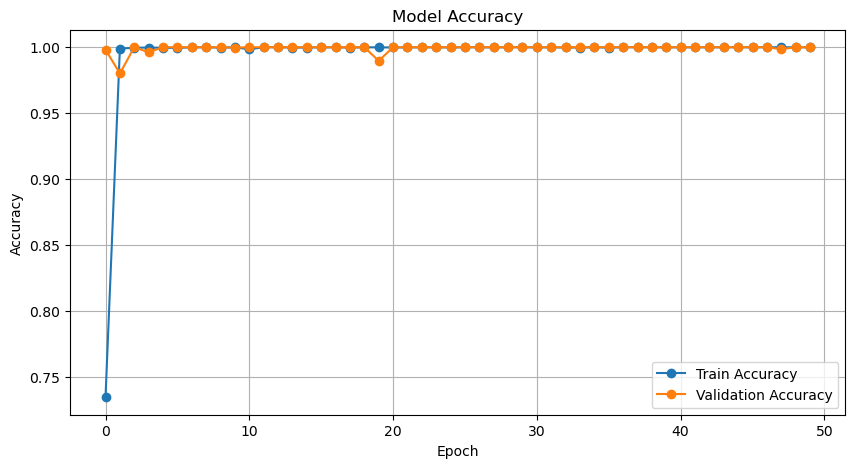

In [62]:
# Evaluate the model and visualize results
# Accuracy and loss plots
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("UNSW_Accuracy_binary.png")
plt.show()

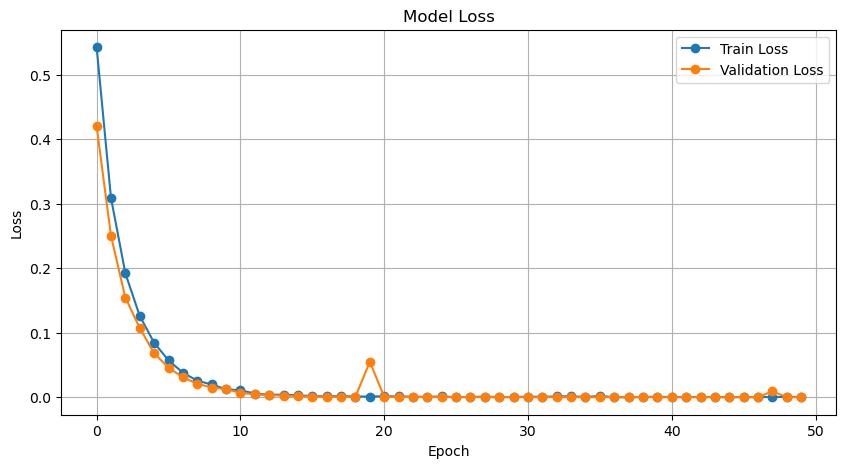

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("UNSW_loss_binary.png")
plt.show()

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step


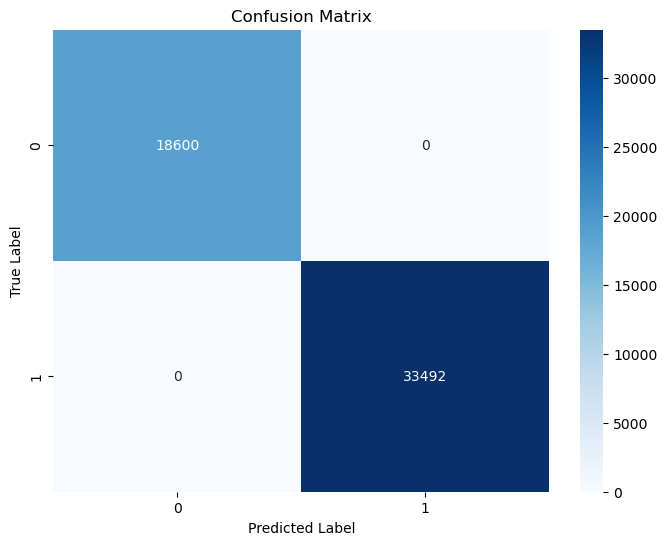

In [64]:
# Confusion matrix
y_pred = (ensemble_model.predict([X_test_cnn, X_test_cnn, X_test]) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('UNSW_confusion_matrix_binary.png')
plt.show()

In [65]:
# Classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18600
         1.0       1.00      1.00      1.00     33492

    accuracy                           1.00     52092
   macro avg       1.00      1.00      1.00     52092
weighted avg       1.00      1.00      1.00     52092



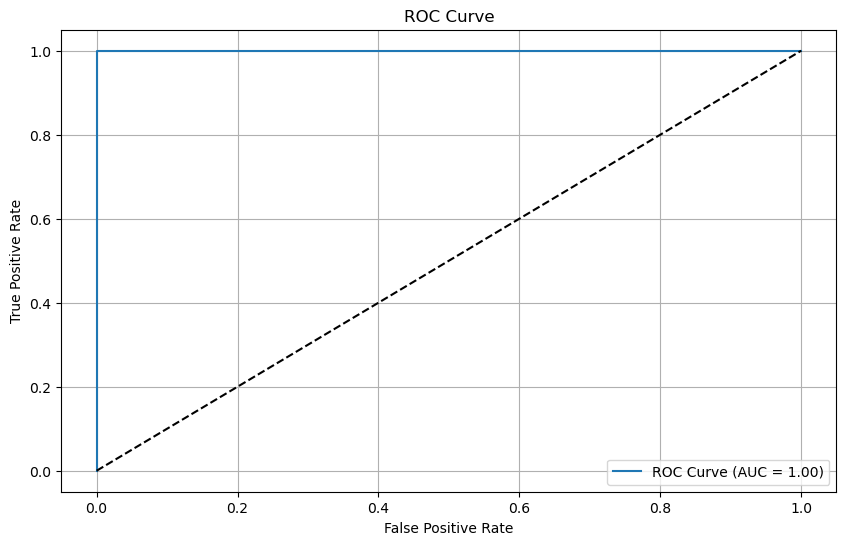

In [66]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("UNSW_ROC_binary.png")
plt.show()

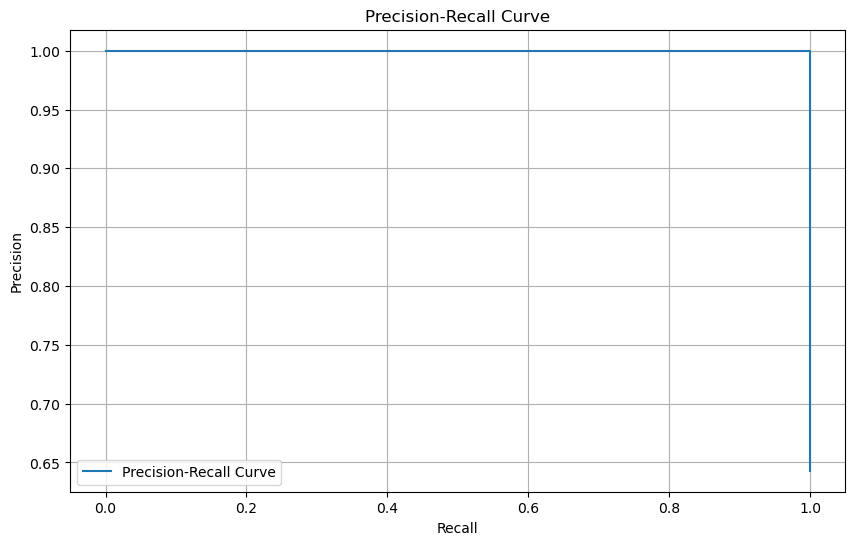

In [67]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig("UNSW_precision_recall_binary.png")
plt.show()

In [68]:
# Extract and plot attention weights
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

# Check the shape of the attention weights to ensure it matches the number of features
print(f"Shape of attention_weights_test: {attention_weights_test.shape}")


1628/1628 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step
Shape of attention_weights_test: (52092, 3)


In [69]:
# Assuming the combined features vector has 22 features after attention
avg_attention_weights = np.mean(attention_weights_test, axis=0)

attention_df = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(avg_attention_weights.shape[0])],
    'Attention Weight': avg_attention_weights
})

print(attention_df)  # Verify the DataFrame before plotting


     Feature  Attention Weight
0  Feature_0      3.529466e-01
1  Feature_1      6.207189e-07
2  Feature_2      6.470294e-01


In [70]:
print(f"Combined features shape before attention: {combined.shape}")

Combined features shape before attention: (None, 3)


In [71]:
# Combine weighted outputs
cnn_weighted_output = Lambda(lambda x: x * weights['cnn'])(cnn_model.output)
lstm_weighted_output = Lambda(lambda x: x * weights['lstm'])(lstm_model.output)
fnn_weighted_output = Lambda(lambda x: x * weights['fnn'])(fnn_model.output)

In [72]:
# Ensure each model output has an appropriate number of features before concatenation
cnn_weighted_output = Dense(10, activation='relu')(cnn_weighted_output)
lstm_weighted_output = Dense(10, activation='relu')(lstm_weighted_output)
fnn_weighted_output = Dense(2, activation='relu')(fnn_weighted_output)

# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Verify the shape after concatenation
print(f"Combined features shape before attention: {combined.shape}")

Combined features shape before attention: (None, 22)


In [73]:
# Apply attention mechanism on combined output
attention_output, attention_weights = attention_mechanism(combined)

In [74]:
# Check the shape of the attention weights to ensure it matches the number of features
print(f"Shape of attention_weights_test: {attention_weights_test.shape}")

# Calculate average attention weights and plot
avg_attention_weights = np.mean(attention_weights_test, axis=0)

attention_df = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(avg_attention_weights.shape[0])],
    'Attention Weight': avg_attention_weights
})

print(attention_df)  # Verify the DataFrame before plotting


Shape of attention_weights_test: (52092, 3)
     Feature  Attention Weight
0  Feature_0      3.529466e-01
1  Feature_1      6.207189e-07
2  Feature_2      6.470294e-01


In [75]:
# Ensure each model output has the correct number of features before concatenation
cnn_weighted_output = Dense(10, activation='relu')(cnn_weighted_output)
lstm_weighted_output = Dense(10, activation='relu')(lstm_weighted_output)
fnn_weighted_output = Dense(2, activation='relu')(fnn_weighted_output)

# Combine weighted outputs
combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Verify the shape after concatenation
print(f"Combined features shape before attention: {combined.shape}")  # Should be (None, 22)

Combined features shape before attention: (None, 22)


In [76]:
# Apply attention mechanism on combined output
attention_output, attention_weights = attention_mechanism(combined)

# Re-evaluate the attention weights
attention_model = Model(inputs=ensemble_model.inputs, outputs=ensemble_model.get_layer('attention_weights').output)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

# Check the shape of the attention weights to ensure it matches the number of features
print(f"Shape of attention_weights_test: {attention_weights_test.shape}")  # Should be (num_samples, 22)

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step
Shape of attention_weights_test: (52092, 3)


In [77]:
# Define attention mechanism
def attention_mechanism(inputs):
    # Dense layer to generate attention weights for each feature
    attention_weights = Dense(inputs.shape[-1], activation='softmax', name='attention_weights')(inputs)
    
    # Apply the attention weights to the inputs
    attention_output = Multiply(name='attention_output')([inputs, attention_weights])
    
    return attention_output, attention_weights

In [78]:
# Combine weighted outputs
cnn_weighted_output = Dense(10, activation='relu')(cnn_weighted_output)
lstm_weighted_output = Dense(10, activation='relu')(lstm_weighted_output)
fnn_weighted_output = Dense(2, activation='relu')(fnn_weighted_output)

combined = concatenate([cnn_weighted_output, lstm_weighted_output, fnn_weighted_output], name='combined_features')

# Verify the shape of the combined features
print(f"Combined features shape before attention: {combined.shape}")  # Should be (None, 22)


Combined features shape before attention: (None, 22)


In [79]:
# Apply attention mechanism on combined output
attention_output, attention_weights = attention_mechanism(combined)

# Re-evaluate the attention weights
attention_model = Model(inputs=ensemble_model.inputs, outputs=attention_weights)
attention_weights_test = attention_model.predict([X_test_cnn, X_test_cnn, X_test])

# Check the shape of the attention weights to ensure it matches the number of features
print(f"Shape of attention_weights_test: {attention_weights_test.shape}")  # Should be (num_samples, 22)

1628/1628 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step
Shape of attention_weights_test: (52092, 22)


In [80]:
# Calculate average attention weights across all samples
avg_attention_weights = np.mean(attention_weights_test, axis=0)

# Create a DataFrame for visualization
attention_df = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(avg_attention_weights.shape[0])],
    'Attention Weight': avg_attention_weights
})

# Print the DataFrame to inspect
print(attention_df)


       Feature  Attention Weight
0    Feature_0          0.044766
1    Feature_1          0.045094
2    Feature_2          0.045871
3    Feature_3          0.044814
4    Feature_4          0.044649
5    Feature_5          0.044696
6    Feature_6          0.045459
7    Feature_7          0.045372
8    Feature_8          0.045586
9    Feature_9          0.045874
10  Feature_10          0.046894
11  Feature_11          0.047354
12  Feature_12          0.045776
13  Feature_13          0.045928
14  Feature_14          0.044992
15  Feature_15          0.043520
16  Feature_16          0.046052
17  Feature_17          0.046644
18  Feature_18          0.045743
19  Feature_19          0.045862
20  Feature_20          0.044836
21  Feature_21          0.044163


In [81]:
# Assuming df_selected.columns contains the real feature names
feature_names = ['dur','proto','service','state','sbytes','dbytes','dload','sloss','sinpkt','sjit','swin','stcpb','dtcpb',
'dwin','synack','ackdat','dmean','trans_depth','ct_state_ttl','ct_dst_src_ltm','ct_ftp_cmd','ct_src_ltm']

# Create a DataFrame for visualization with actual feature names
attention_df = pd.DataFrame({
    'Feature': feature_names,
    'Attention Weight': avg_attention_weights
})

# Print the DataFrame to inspect
print(attention_df)

           Feature  Attention Weight
0              dur          0.044766
1            proto          0.045094
2          service          0.045871
3            state          0.044814
4           sbytes          0.044649
5           dbytes          0.044696
6            dload          0.045459
7            sloss          0.045372
8           sinpkt          0.045586
9             sjit          0.045874
10            swin          0.046894
11           stcpb          0.047354
12           dtcpb          0.045776
13            dwin          0.045928
14          synack          0.044992
15          ackdat          0.043520
16           dmean          0.046052
17     trans_depth          0.046644
18    ct_state_ttl          0.045743
19  ct_dst_src_ltm          0.045862
20      ct_ftp_cmd          0.044836
21      ct_src_ltm          0.044163


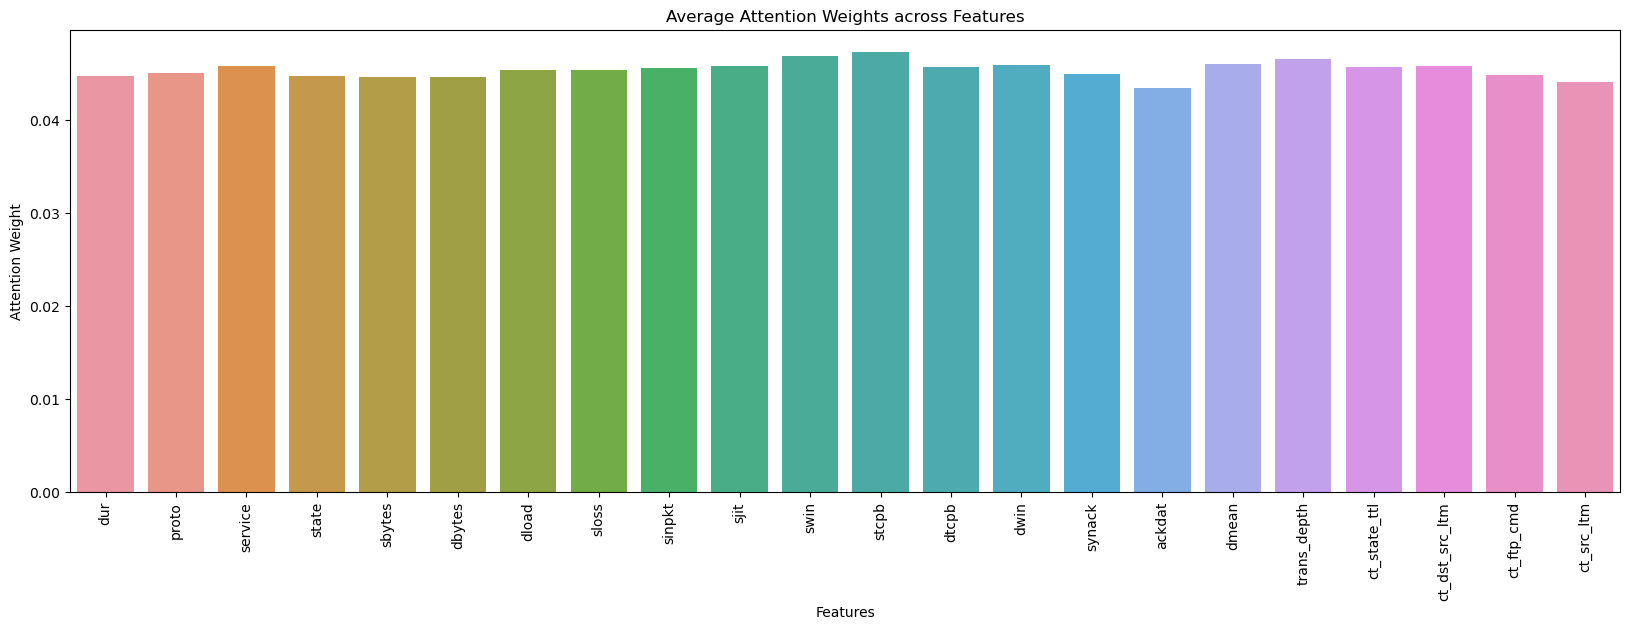

In [82]:
# Plot the attention weights with real feature names
plt.figure(figsize=(20, 6))
sns.barplot(x='Feature', y='Attention Weight', data=attention_df)
plt.title('Average Attention Weights across Features')
plt.xlabel('Features')
plt.ylabel('Attention Weight')
plt.xticks(rotation=90)
plt.savefig('UNSW_attention_weight_binary.png')
plt.show()